In [ ]:
%%bash
mkdir samples
mkdir data
git clone https://github.com/lcsdn/OT-GAN.git
mv OT-GAN ot_gan

In [ ]:
import torch
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

from ot_gan.generator import Generator
from ot_gan.critic import Critic
from ot_gan.sinkhorn import Sinkhorn
from ot_gan.gan import OT_GAN

Hyperparameters definition.



In [ ]:
dataset = 'fashion' # choice of dataset: 'digits' or 'fashion'
num_epochs = 200
num_features = 32 # Number of features in generator and critic networks
num_channels = 1 # Number of channels in the images
dim_critic = num_features * 4
dim_noise = 100
lr = 2e-4
batch_size = 8000
num_fixed_samples = 100
sinkhorn_epsilon = 10
sinkhorn_num_iter = 50
n_gen = 3 # Generator is trained n_gen times for each critic training step
num_labels = 10 # Number of labels in the dataset, used for conditional generation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Loading the data with torchvision.

In [ ]:
if dataset == 'digits':
    torchvision_dataset = torchvision.datasets.MNIST
else:
    torchvision_dataset = torchvision.datasets.FashionMNIST

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_set = torchvision_dataset('data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

Let us visualise some samples.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


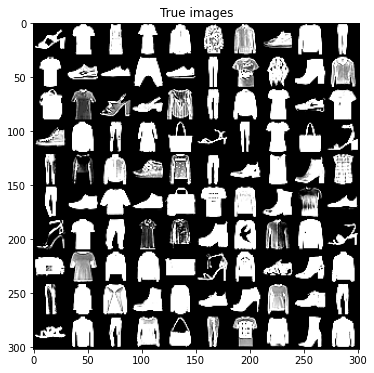

In [ ]:
for (images, _) in train_loader:
    break
grid = make_grid(images[:100], nrow=10)
plt.figure(figsize=(16, 6))
plt.title('True images')
plt.imshow(grid.permute(1, 2, 0))
plt.show()

Model initialisation.

In [ ]:
generator = Generator(num_channels, dim_noise, num_features).to(device)
critic = Critic(num_channels, num_features, dim_critic).to(device)
sinkhorn = Sinkhorn(reg_param=sinkhorn_epsilon, num_iter=sinkhorn_num_iter)

opt_generator = optim.Adam(generator.parameters(), lr=lr)
opt_critic = optim.Adam(critic.parameters(), lr=lr)

gan = OT_GAN(
    generator=generator,
    critic=critic,
    sinkhorn=sinkhorn,
    opt_generator=opt_generator,
    opt_critic=opt_critic,
)

fixed_noise = torch.randn(num_fixed_samples, dim_noise, 1, 1, device=device)
fixed_noise_labels = torch.randint(num_labels, size=(num_fixed_samples,), device=device)

Training the OT GAN.

In [ ]:
losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        batch_size = images.shape[0]
        images = images.to(device)
        labels = labels.to(device)
        noise = torch.randn(batch_size, dim_noise, 1, 1, device=device)

        if i % (n_gen+1) == 0:
            loss = gan.train_critic_step(images, labels, noise)
        else:
            loss = gan.train_generator_step(images, labels, noise)
        
        losses.append(loss.item())

    print('Epoch {}/{}, loss {:.2f}'.format(epoch+1, num_epochs, losses[-1]))
    gan.eval()
    with torch.no_grad():
        fixed_noise_img = gan(fixed_noise, fixed_noise_labels)
    grid = make_grid(fixed_noise_img, nrow=10)
    save_image(grid, f'samples/fixed_noise_epoch_{epoch+1}.png')
    gan.train()

Let us visualise some generated images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


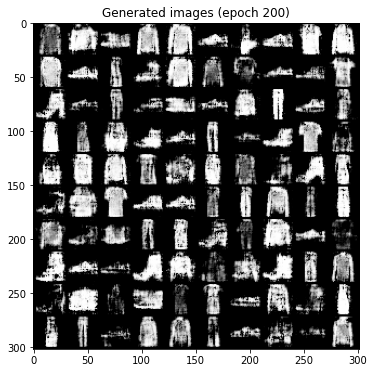

In [ ]:
generator.eval()
with torch.no_grad():
    fixed_noise_img = gan(fixed_noise, fixed_noise_labels)
    
grid = make_grid(fixed_noise_img, nrow=10)
plt.figure(figsize=(16, 6))
plt.title(f'Generated images (epoch {epoch})')
plt.imshow(grid.detach().cpu().permute(1, 2, 0))
plt.show()

Let us visualise the loss evolution during training.

In [ ]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.title('Loss evolution during training')
plt.show()

As the loss is adversarial, it is hard to interprete its evolution. Though it could be a good sign if it is stabilising, as it could mean it is close to an optimal saddle point.

We can visualise the effect of interpolating the noise inputs, as done in https://arxiv.org/abs/1511.06434

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


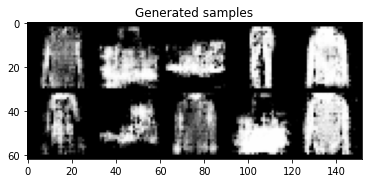

In [ ]:
num_samples = 10
noise_samples = torch.randn(num_samples, dim_noise, 1, 1, device=device)

gan.eval()
with torch.no_grad():
    generated_samples = gan(noise_samples, None)

grid = make_grid(generated_samples, nrow=5)
plt.title('Generated samples')
plt.imshow(grid.detach().cpu().permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


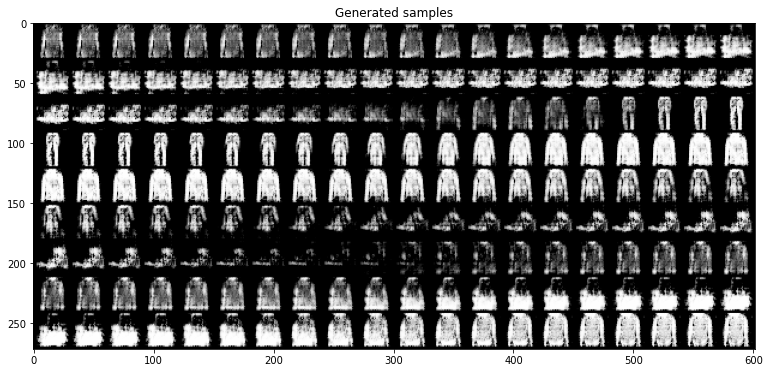

In [ ]:
interpolation_length = 20
num_interpolated_samples = interpolation_length * (num_samples - 1)

interpolated_noise = torch.zeros(num_interpolated_samples, dim_noise, 1, 1, device=device)
for i in range(num_interpolated_samples):
    start_noise = noise_samples[i//interpolation_length]
    end_noise = noise_samples[i//interpolation_length+1]
    t = (i%interpolation_length) / interpolation_length
    interpolated_noise[i] = (1-t) * start_noise + t * end_noise

gan.eval()
with torch.no_grad():
    interpolated_samples = gan(interpolated_noise, None)

grid = make_grid(interpolated_samples, nrow=interpolation_length)
plt.figure(figsize=(16, 6))
plt.title('Interpolated samples')
plt.imshow(grid.detach().cpu().permute(1, 2, 0))
plt.show()